**Problem statement**: <br>To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries
Lets import all the required libraries and mount the google drive

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Lets mount the google drive from the below code

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

####**unzip the data skin cancer data**

In [3]:
!unzip /content/gdrive/MyDrive/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Defining some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Lets visualize one instance of all the nine classes present in the dataset

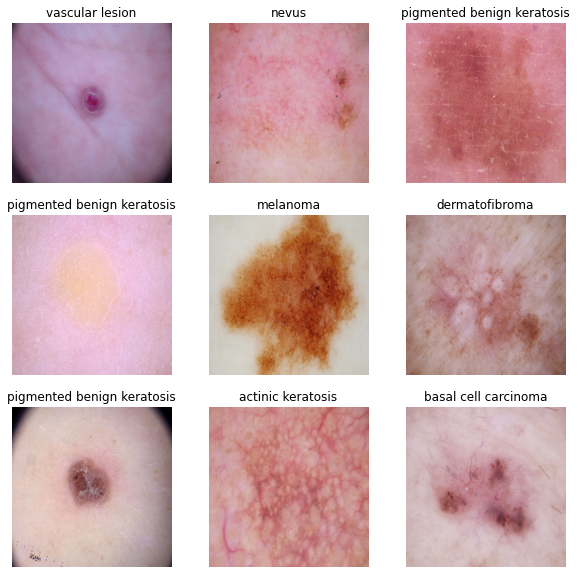

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####Model-1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Lets find the minimum and maximum values of normalised data

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in '[0,1]'.
print(np.min(first_image), np.max(first_image)) 

0.021568628 0.9534314


**Creating the model-1** <br>
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.

In [14]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model-1
Choosing an appropirate optimiser and loss function for model training 

choosing the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the Model-1

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 87ms/step - loss: 2.0218 - accuracy: 0.2186 - val_loss: 1.8381 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7110 - accuracy: 0.4004 - val_loss: 1.4885 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4519 - accuracy: 0.4855 - val_loss: 1.3907 - val_accuracy: 0.5347
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3212 - accuracy: 0.5436 - val_loss: 1.3892 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2054 - accuracy: 0.5757 - val_loss: 1.5342 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0918 - accuracy: 0.6188 - val_loss: 1.4379 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0848 - accuracy: 0.6155 - val_loss: 1.5063 - val_accuracy: 0.5123
Epoch 8/20
5

### Visualizing training results

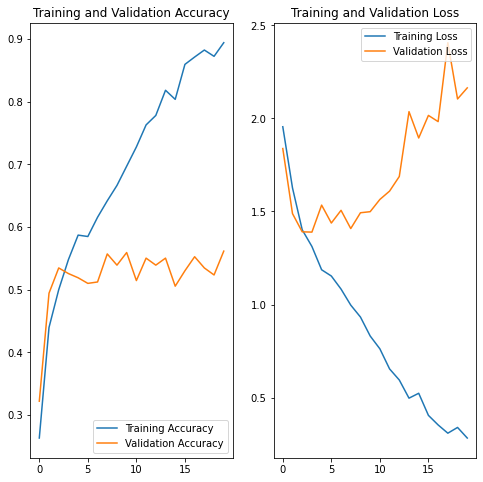

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings from the Above Model Visualisation for Model-1

This is clearly overfitting because:<br>
- Training Accuracy is More where as Validation Accuracy is very less and decreasing fashion
- Where as Training Loss is Less and Validation Loss is increasing as we should minimise them
- Lets use augmentation strategies and overcome the overfitting by adding drop out layers 

####Data Augmentation
Lets try to rotate, flip,zoom the images and identify their classes

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

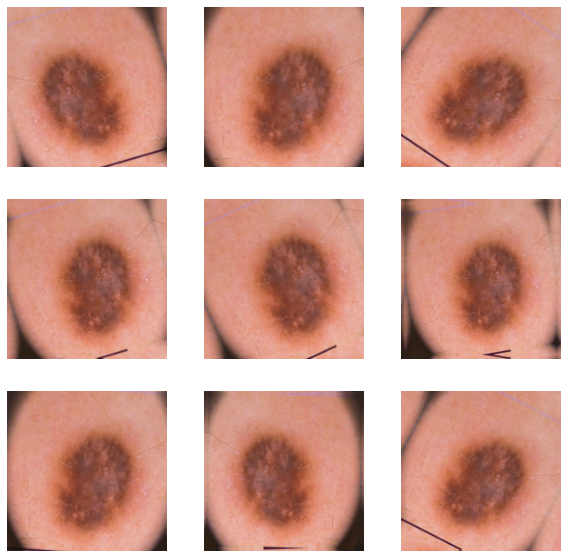

In [20]:
# visualizing how our augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model-2
### Create the model, compile and train the model
### DropOut


Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model-2
Choosing the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function for compiling the model


In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model-2

In [23]:
## Your code goes here, note: train your model for 20 epochs
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 31ms/step - loss: 2.1038 - accuracy: 0.2254 - val_loss: 1.6474 - val_accuracy: 0.4206
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5890 - accuracy: 0.4445 - val_loss: 1.4812 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4478 - accuracy: 0.4875 - val_loss: 1.4326 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4138 - accuracy: 0.5024 - val_loss: 1.3986 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3491 - accuracy: 0.5216 - val_loss: 1.4081 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3672 - accuracy: 0.5114 - val_loss: 1.3942 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.2522 - accuracy: 0.5415 - val_loss: 1.3137 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing the results

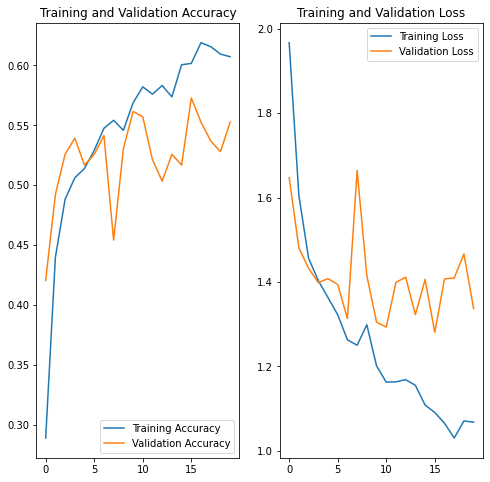

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings For Model-2
**Observations**
- The model has improved when compared with Model-1, when we used the drop outs but still the model is overfitting
- The reason behind this is because of class imbalance ratio 
- There are few layers which are dominating the other layers need to balance them to improve accuracy

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Lets check the distribution of all the classes

In [25]:
## Your code goes here.
from glob import glob
path_list=[x for x in glob(os.path.join(data_dir_train,'*','*jpg'))]
lesion_list=[os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [26]:
dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df.groupby('Label').count().sort_values(by='Path',ascending=False)

,Path
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [27]:
original_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
Name: Label, dtype: float64

In [28]:
## Your code goes here.
for i in class_names:
  print("The {0} has {1} samples".format(i,len(list(data_dir_train.glob(str(i)+'/*')))))

The actinic keratosis has 114 samples
The basal cell carcinoma has 376 samples
The dermatofibroma has 95 samples
The melanoma has 438 samples
The nevus has 357 samples
The pigmented benign keratosis has 462 samples
The seborrheic keratosis has 77 samples
The squamous cell carcinoma has 181 samples
The vascular lesion has 139 samples


#### Findings from Class distribution
- **Seborrheic keratosis has the least number of samples**
- **pigmented benign keratosis,melanoma,basal cell carcinoma,nevus dominate the data in terms proportionate number of samples respectively**


####Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
   p = Augmentor.Pipeline(path_to_training_dataset + i)
   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40C00FFE80>: 100%|██████████| 500/500 [00:17<00:00, 28.60 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4120F03320>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F415D7001D0>: 100%|██████████| 500/500 [00:17<00:00, 28.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4120EB5908>: 100%|██████████| 500/500 [00:17<00:00, 28.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F4120EC3128>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F4120F534E0>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40C01329E8>:   0%|          | 1/500 [00:00<01:29,  5.56 Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4120F21DD8>: 100%|██████████| 500/500 [00:17<00:00, 27.81 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F40C00D6128>: 100%|██████████| 500/500 [00:42<00:00, 11.78 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F4120F28FD0>:   0%|          | 1/500 [00:00<01:00,  8.22 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40C00C76D8>: 100%|██████████| 500/500 [00:17<00:00, 28.36 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4120EB55C0>: 100%|██████████| 500/500 [00:17<00:00, 28.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028386.jpg_41273f7b-8f84-4d10-b899-c3b985d81e33.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028389.jpg_5749a3e0-3240-4616-8a46-e13faffad736.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026070.jpg_08e4b0a1-b2c9-46d7-b485-6984de55d3e1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028662.jpg_57bbec06-08d4-4997-96fe-30ce6b62448b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025064.jpg_7ff3d019-de40-456d-9a78-8e2b17b5d68c.jpg',


In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [37]:
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

####Create a training dataset
Lets utilise the 500 samples created in the output folder for each classes in a training dataset  

In [39]:
data_dir_train=str(path_to_training_dataset)+'/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation_new = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

#### Model-3
####Creating model (make sure to include normalization)
Lets go ahead and create a model including drop outs, by normalising the layers with data augmentation strategy 

In [42]:
model = Sequential([
  data_augmentation_new,
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

Added appropriate layers and neurons for improving the accuracy for train and validation data

#### Compiling the model (Choosing the optimizer and loss function appropriately
choosing Adam optimiser and SparseCategoricalCrossentropy loss function to compile the model-*3*

In [43]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/30
169/169 [==============================] - 37s 211ms/step - loss: 1.9992 - accuracy: 0.2216 - val_loss: 1.5283 - val_accuracy: 0.4165
Epoch 2/30
169/169 [==============================] - 36s 208ms/step - loss: 1.5356 - accuracy: 0.3940 - val_loss: 1.3640 - val_accuracy: 0.4751
Epoch 3/30
169/169 [==============================] - 36s 208ms/step - loss: 1.4020 - accuracy: 0.4650 - val_loss: 1.3235 - val_accuracy: 0.4952
Epoch 4/30
169/169 [==============================] - 36s 206ms/step - loss: 1.3345 - accuracy: 0.4693 - val_loss: 1.3120 - val_accuracy: 0.5108
Epoch 5/30
169/169 [==============================] - 36s 208ms/step - loss: 1.2772 - accuracy: 0.5003 - val_loss: 1.2101 - val_accuracy: 0.5197
Epoch 6/30
169/169 [==============================] - 36s 207ms/step - loss: 1.2153 - accuracy: 0.5262 - val_loss: 1.1777 - val_accuracy: 0.5330
Epoch 7/30
169/169 [==============================] - 36s 208ms/step - loss: 1.1769 - accuracy: 0.5326 - val_loss: 1.2278 - val_ac

#### Visualizing the model results
Lets visualise the obtained results from Model-3

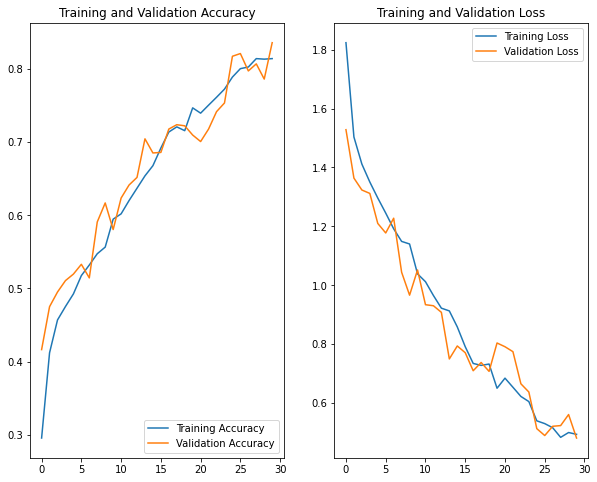

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
**From the above graph after the class rebalance using augmentation and adding drop outs helped in overcoming the overfitting and the training and validation accuracy are almost together, and the loss pattern for the above graph is quite similar.**
- Model-1 : Had overfitted the data so introduced data augmentation techniques for rotating , zoom and random flip images , in  creating model-2  
- Model-2 : Introduced drop out layers in CNN layers and used data augmentation strategy for improvising the model , but still the model is not performing well and it still overfits
The reason behind is due class imbalance that has covered in the model-3
- Model-3 : Handled class imbalance and added new similar samples and used augmentation strategy , drop outs altogether has improved the model performance in terms of Accuracy and Loss over train and validation data
